In [1]:
import os
from segm.model.factory import load_model
from segm.data.factory import create_dataset
from segm.model.factory import create_segmenter 
import segm.utils.torch as ptu
from segm.flops import get_dataset_validation_path, dataset_prepare, InferenceDataset
from torchvision import transforms
from  segm.model.factory import load_model
from segm.data.utils import STATS
from torch.utils.data import DataLoader




/media/caduser/MyBook/chau/miniconda3/envs/chau/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_dir = '/media/caduser/MyBook/chau/algm-segmenter/runs'
model_path =  f'{model_dir}/vit_ti_16/checkpoint.pth'
root_dir = os.getenv('DATASET')

model, variant = load_model(model_path)
root_dir = os.getenv('DATASET')
input_size = variant['dataset_kwargs']['crop_size']
normalization = variant['dataset_kwargs']['normalization']

dataset = 'ade20k'
dataset_path, dataset_txt_path =  get_dataset_validation_path(dataset, root_dir)
stats = STATS[normalization]
batch_size = 1 
validation_loader = dataset_prepare(dataset_path, dataset_txt_path, stats, batch_size, input_size)

vis_transforms = transforms.Compose([
   transforms.Resize((input_size, input_size)),  # Resize the image to the input size
])

tensor_transforms = transforms.Compose([
   transforms.Resize((input_size, input_size)),  # Resize the image to the input size
   transforms.ToTensor(),          # Convert image to tensor
   transforms.Normalize(stats["mean"], stats["std"]) # Normalize with mean and std
])

In [10]:
from torch.utils.data import Dataset
from PIL import Image

class InferenceDataset(Dataset):

    def __init__(self, root_dir, transform=None, vis_transform=None, txt_file=None):
        self.root_dir = root_dir
        self.transform = transform
        self.vis_transform = vis_transform

        # If txt_file is provided, read image names from it
        if txt_file:
            with open(txt_file, 'r') as file:
                self.image_files = [os.path.join(root_dir, line.strip() + '.jpg') for line in file.readlines()]
        else:
            # Otherwise, load all image paths from root_dir and subfolders
            self.image_files = self._load_image_paths(root_dir)

    def _load_image_paths(self, root_dir):
        image_files = []
        for dirpath, _, filenames in os.walk(root_dir):
            for file in filenames:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                    image_files.append(os.path.join(dirpath, file))
        return image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        image_vis = None
        output = ()
        if self.transform:
            image_tensor = self.transform(image)
        if self.vis_transform:
            image_vis = self.vis_transform(image)
        return image_tensor, image_vis

dataset = InferenceDataset(root_dir=dataset_path, transform=tensor_transforms, vis_transform=vis_transforms)


sample_idx = 20
sample = dataset[sample_idx]


    

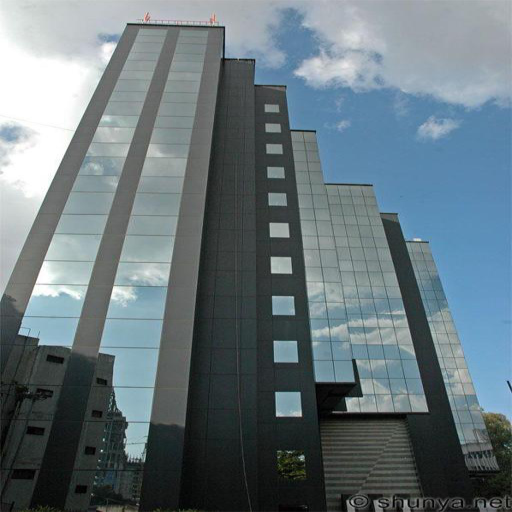

In [12]:
sample[1]

In [16]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
image_tensor = sample[0].repeat(1,1,1,1).to(device)

In [18]:
model = model.to(device)
model(image_tensor)

tensor([[[[ 1.2511,  1.2511,  1.2511,  ..., -0.1723, -0.1723, -0.1723],
          [ 1.2511,  1.2511,  1.2511,  ..., -0.1723, -0.1723, -0.1723],
          [ 1.2511,  1.2511,  1.2511,  ..., -0.1723, -0.1723, -0.1723],
          ...,
          [ 1.4542,  1.4542,  1.4542,  ...,  0.6933,  0.6933,  0.6933],
          [ 1.4542,  1.4542,  1.4542,  ...,  0.6933,  0.6933,  0.6933],
          [ 1.4542,  1.4542,  1.4542,  ...,  0.6933,  0.6933,  0.6933]],

         [[ 4.2728,  4.2728,  4.2728,  ...,  4.1758,  4.1758,  4.1758],
          [ 4.2728,  4.2728,  4.2728,  ...,  4.1758,  4.1758,  4.1758],
          [ 4.2728,  4.2728,  4.2728,  ...,  4.1758,  4.1758,  4.1758],
          ...,
          [ 7.1548,  7.1548,  7.1548,  ...,  6.2463,  6.2463,  6.2463],
          [ 7.1548,  7.1548,  7.1548,  ...,  6.2463,  6.2463,  6.2463],
          [ 7.1548,  7.1548,  7.1548,  ...,  6.2463,  6.2463,  6.2463]],

         [[14.2305, 14.2305, 14.2305,  ..., 12.5378, 12.5378, 12.5378],
          [14.2305, 14.2305, 1

In [19]:
model

Segmenter(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (mlp): FeedForward(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
      )
      (1): Block(
       